# **Gene Array Report**

Author: Jonathan Yin

## **Data Overview**

The dataset consists of 33 CSV files representing well slides, organized into 11 sets with each set performed in triplicate.

#### Slide Design

Each slide contains 384 wells arranged in a 16×24 formation, with 320 unique genes and 64 controls. The genes are located in the center 16×20 region, while the controls occupy the outer 2 columns on each side. There are 4 types of controls used: "rf", "fit1", "bscl2", and "rfnotDL".

![image](plots/ArrayDesign.png)

#### Measurements

For measurement purposes, each well on each slide was captured 7 times, with each capture generating a 130-dimensional feature vector (X1, X2, ..., X130).


## **Data Cleaning**


In [1]:
import os
import pandas as pd
from pathlib import Path

slidefiles_dir = Path("data/SlideFiles")
csv_files = os.listdir(slidefiles_dir)

raw_df = pd.DataFrame()
for csv_file in csv_files:
    file_path = slidefiles_dir / csv_file
    raw_df = pd.concat([raw_df, pd.read_csv(file_path)])

raw_df.drop(columns=["type.f"], inplace=True)
raw_df = raw_df.sort_values(by=["slide", "well"])

### Feature Aggregation

First, we aggregate the 7 well measurements to produce a 130-dimensional feature vector for each well. We do this by taking the median of the 7 measurements across the 130 features. This makes the well measurements more robust to noise and easier to analyze.


In [2]:
from constants import METADATA_COLS, FEATURE_COLS

df = raw_df.groupby(["slide", "well"]).agg(
    {
        **{col: "median" for col in FEATURE_COLS},
        **{col: "first" for col in METADATA_COLS if col not in ["well", "slide"]},
    }
)
# Reset index to make slide and well regular columns again and re-order columns to match raw_df
df = df.reset_index()
df = df[raw_df.columns.tolist()]
df = df.sort_values(by=["slide", "well"])

### Slide-level Normalization

To be able to compare wells across different slides, we need to account for potential systematic differences between slides.

Examining the distribution of feature vectors for gene wells within a slide reveals that each of the 130 dimensions approximately follows a normal distribution.

Since genes are randomly assigned to a set, we can reasonably assume that the underlying distribution of these feature vectors should be consistent across all slides. Any systematic differences observed between slides are likely due to technical variations rather than biological differences.

To normalize these slide-specific effects, we can apply z-score normalization on a per-slide basis: for each feature dimension, we subtract the mean and divide by the standard deviation of the gene wells' measurements within that slide. This standardization procedure allows for more meaningful comparisons of wells across different slides by removing slide-specific biases. Furthermore, it makes it easier to compare the various dimensions of the feature vectors since now they are all on the same scale.


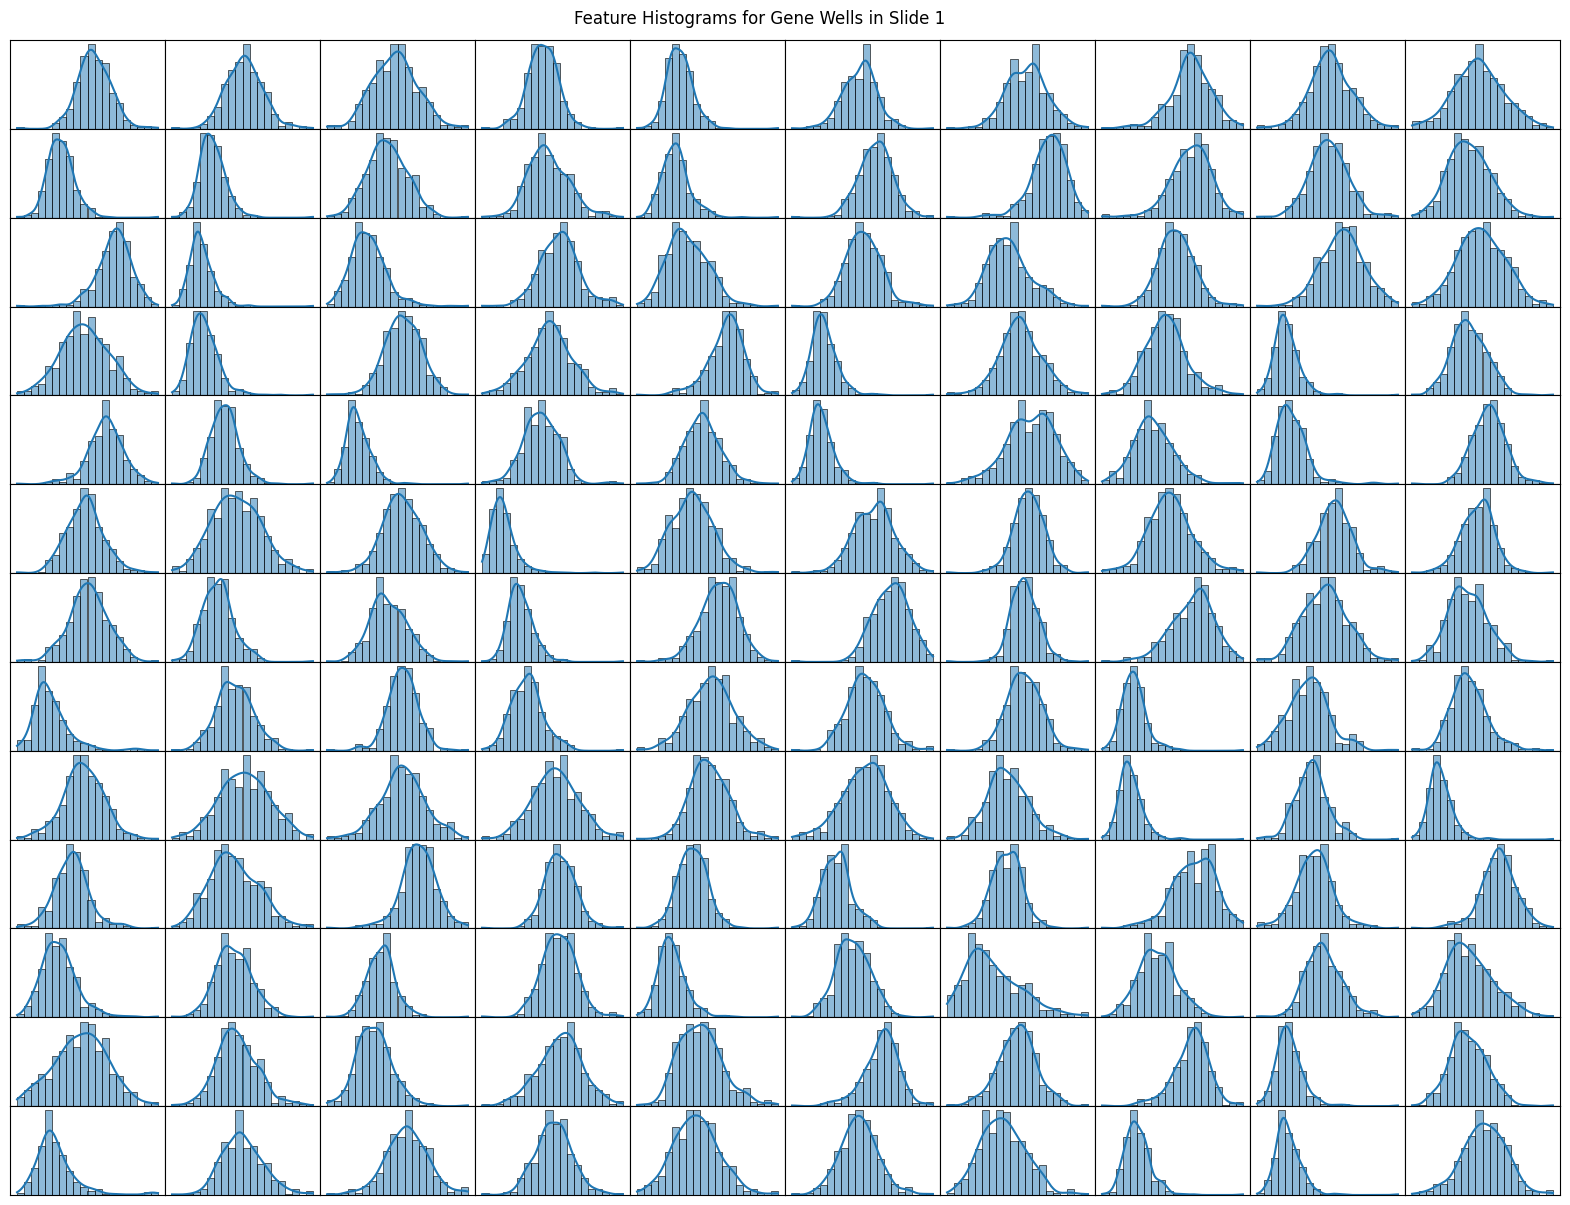

In [3]:
from plotting_utils import plot_feature_histograms

for slide_number in df["slide"].unique()[:1]:
    plot_feature_histograms(
        df[(df["slide"] == slide_number) & (df["type"] == "gene")],
        f"Feature Histograms for Gene Wells in Slide {slide_number}",
    )

In [4]:
for slide_number in df["slide"].unique():
    slide_indices = df["slide"] == slide_number
    gene_indices = slide_indices & (df["type"] == "gene")

    if gene_indices.any():
        # Calculate mean and standard deviation for feature columns
        gene_means = df.loc[gene_indices, FEATURE_COLS].mean()
        gene_stds = df.loc[gene_indices, FEATURE_COLS].std()

        # Normalize all rows for this slide by subtracting mean and dividing by std
        for feature in FEATURE_COLS:
            df.loc[slide_indices, feature] = (
                df.loc[slide_indices, feature] - gene_means[feature]
            ) / gene_stds[feature]
    else:
        print(f"Warning: No gene rows found for slide {slide_number}")

#### Alternative Approach: Negative Control-based Normalization

Another approach to normalize slide-level differences is to use negative control (rf) wells as reference points. Since these wells should be identical across slides, any variations likely represent technical differences rather than biological ones.

This approach involves:

1. Computing a slide-specific baseline by taking the median of the 24 rf wells on each slide (creating a 130-dimensional reference vector per slide)
2. Establishing a global baseline by calculating the median across all 792 rf wells (33 slides × 24 wells)
3. Normalizing each well's measurements by subtracting the slide-specific baseline and dividing by a measure of variability

The z-score normalization approach is preferable to the negative control-based normalization for several reasons:

1. **More robust statistics**: By using all gene wells on a slide (320 wells), we have a larger sample size for calculating means and standard deviations compared to using only 24 rf wells, resulting in more stable normalization parameters.

2. **Simpler implementation**: The z-score approach requires fewer computational steps and doesn't need to establish both slide-specific and global baselines.

3. **Established statistical properties**: Z-score normalization produces features with zero mean and unit variance, which is beneficial for many downstream methods that assume standardized inputs.

4. **Direct comparability**: After z-score normalization, features across all slides are immediately comparable without additional adjustment steps.


### Triplicate Aggregation

Finally, we aggregate the triplicate slides by taking the median of the feature vectors for each well position. This produces a 130-dimensional feature vector for each well position in the set. This leaves us with 11 slides of 384 wells, each with a 130-dimensional feature vector.

While it is possible to further aggregate the 64 control wells on each slide to produce a single 130-dimensional feature vector for each control, we choose not to do so because we are mainly interested in the gene wells and retaining well-level information is useful downstream to validate our outlier detection methods.


In [5]:
df = df.groupby(["set", "well"]).agg(
    {
        **{col: "median" for col in FEATURE_COLS},
        **{
            col: "first" for col in METADATA_COLS if col not in ["well", "set", "slide"]
        },
    }
)

df = df.reset_index()
columns_to_keep = [col for col in raw_df.columns.tolist() if col != "slide"]
df = df[columns_to_keep]
df = df.sort_values(by=["set", "well"])
df.to_csv("data/cleaned_gene_array_data.csv", index=False)

## **Outlier Detection**

To get a sense of what we are looking for, we first compare the distribution of the gene wells, which are mostly negative hits, to the distribution of the bscl2 wells, which are known to be positive controls. Across a majority of the 130 features, there appears to be a difference in the distribution of the gene wells and the bscl2 wells. However, it's unclear if all positive hits will differ in the same way as the bscl2 wells.


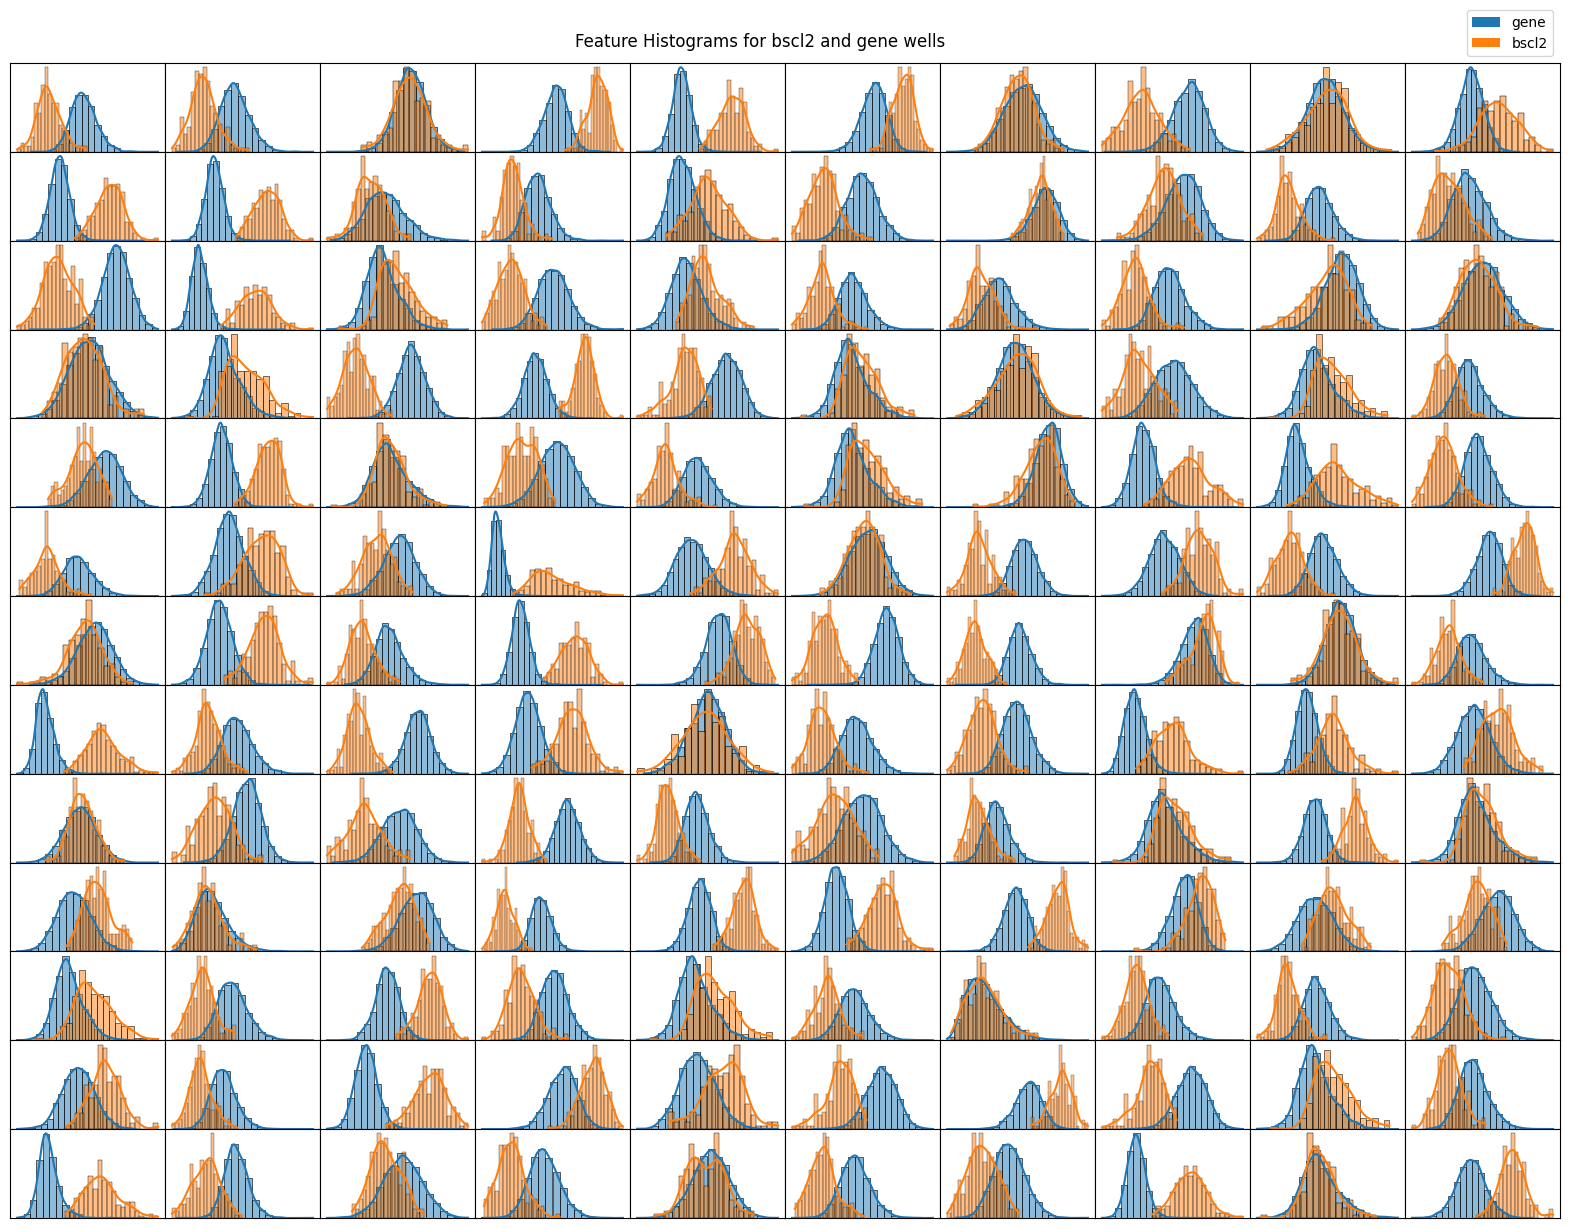

In [6]:
from plotting_utils import compare_feature_histograms

compare_feature_histograms(
    df,
    "gene",
    "bscl2",
    "Feature Histograms for bscl2 and gene wells",
)


#### Outlier Detection Methods

We'll use two different methods to detect outliers in our dataset:

1. **Euclidean Distance**: This method calculates the distance between a well's feature vector and the mean feature vector of all gene wells in the 130-dimensional feature space. Wells with larger Euclidean distances from the mean are considered potential outliers. This approach assumes that outliers are points that are far from the center of the data distribution.

2. **Isolation Forest**: This algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. Outliers require fewer splits to be isolated, resulting in shorter paths in the trees.


Below, we use a euclidean distance threshold to detect outliers. Euclidean distance assigns equal weight to all dimensions of the feature vector, which is acceptable here because we have already normalized the feature vectors to have zero mean and unit variance. To compute distance, we use the mean of the gene wells as the reference point. We then choose a distance threshold that yields 100 genes wells to investigate out of 3520 total gene wells.

We see that this method correctly identifies 99.4% of the bscl2 wells as outliers and 99.4% of the rfnotDL well as outliers as well. It falsely classified 5.7% of rf wells as outliers despite it being a known negative control.


In [7]:
from scipy.spatial import distance
import numpy as np

df_data = df[FEATURE_COLS].values
gene_data = df[df["type"] == "gene"][FEATURE_COLS].values

gene_mean = np.mean(gene_data, axis=0)

df["euclidean_distance"] = df.apply(
    lambda row: distance.euclidean(row[FEATURE_COLS], gene_mean),
    axis=1,
)


# Calculate the threshold using only the gene data
threshold = np.percentile(
    df[df["type"] == "gene"]["euclidean_distance"], (1 - (100 / 3520)) * 100
)

# Create a new column indicating whether each sample exceeds the threshold
df["euclidean_outlier"] = df["euclidean_distance"] > threshold

outlier_summary = df.groupby("type")["euclidean_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)

         count  sum  percentage
type                           
bscl2      176  175   99.431818
fit1        88   10   11.363636
gene      3520  100    2.840909
rf         264   15    5.681818
rfnotDL    176  175   99.431818


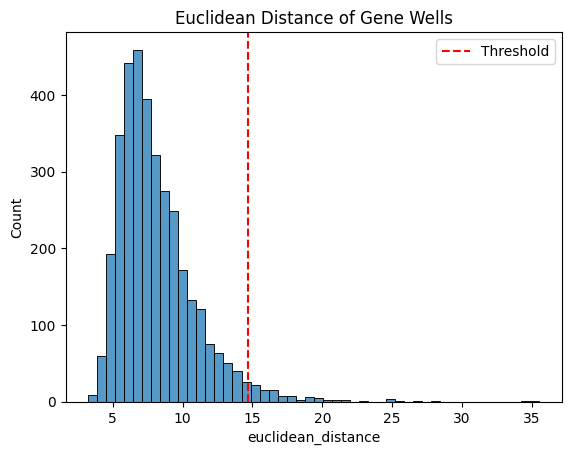

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df[df["type"] == "gene"]["euclidean_distance"], bins=50)
plt.title("Euclidean Distance of Gene Wells")
plt.axvline(
    threshold,
    color="red",
    linestyle="--",
    label="Threshold",
)
plt.legend()
plt.show()


Now, we use the isolation forest method to detect outliers. We fit the isolation forest on the gene wells and then use the model to predict on all wells.

The isolation forest correctly identified 99.4% of the bscl2 wells as outliers and 100% of the rfnotDL wells as outliers, which is a nearly identical true positive rate compared to the euclidean distance method. However, it falsely classified 8.7% of rf wells as outliers, which is a worse false positive rate.

Of the 3520 gene wells, the isolation forest identified 239 gene wells as potential outliers.


In [9]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=425).fit(gene_data)
outlier_scores = clf.predict(df[FEATURE_COLS].values)

df["isolation_forest_outlier"] = outlier_scores == -1

outlier_summary = df.groupby("type")["isolation_forest_outlier"].agg(["count", "sum"])
outlier_summary["percentage"] = (
    outlier_summary["sum"] / outlier_summary["count"]
) * 100
print(outlier_summary)


         count  sum  percentage
type                           
bscl2      176  175   99.431818
fit1        88   23   26.136364
gene      3520  239    6.789773
rf         264   23    8.712121
rfnotDL    176  176  100.000000


There are 100 gene wells that are identified as outliers by both methods. That is, every well identified as an outlier by the euclidean distance threshold was also deemed an outlier by the isolation forest. We will proceed with this set of 100 wells for further investigation.


In [10]:
df["both_outlier"] = df["isolation_forest_outlier"] & df["euclidean_outlier"]

outlier_gene_wells = df[df["both_outlier"] & (df["type"] == "gene")]
print(len(outlier_gene_wells))
outlier_gene_wells[[col for col in METADATA_COLS if col != "slide"]].to_csv(
    "data/outlier_gene_wells.csv", index=False
)


100


# Visualization

Finally, we perform PCA and UMAP dimensionality reduction to visualize the outliers in comparison to the non-outlier wells. This offers a sanity check to ensure that the outliers are indeed potentially interesting to investigate.

To interactively explore the visualizations, open the html files `plots/pca_3d_scatter.html` and `plots/umap_3d_scatter.html`.


In [11]:
def create_dimension_reduction_df(
    transformed_data,
    n_components,
    prefix,
    df,
):
    transformed_data = transformed_data[:, :n_components]
    columns = [f"{prefix}{i + 1}" for i in range(n_components)]
    result_df = pd.DataFrame(transformed_data, columns=columns)

    # Add metadata columns from original DataFrame
    for col in df.columns:
        if col not in FEATURE_COLS:
            result_df[col] = df[col].values

    return result_df

### PCA

Here we see that the outlier gene wells appear to be either at the edges of the gene well cluster or part of other clusters, such as the bscl2 or rfnotDL clusters. Furthermore, as expected, the positive control wells are clustered together and separately from the gene well cluster while the rf wells are clustered alongside the gene wells.

![image](plots/pca_3d_scatter.png)


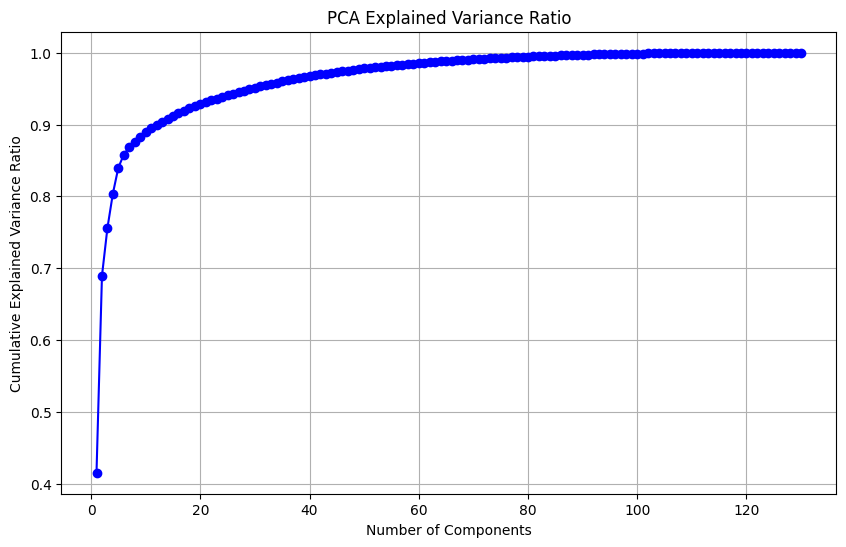

In [12]:
from sklearn.decomposition import PCA
from plotting_utils import plot_3d_scatter, plot_pca_explained_variance


def perform_pca(X_scaled):
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca


X_pca, pca = perform_pca(df_data)

plot_pca_explained_variance(pca)

pca_df = create_dimension_reduction_df(
    X_pca,
    3,
    "PC",
    df,
)

pca_fig = plot_3d_scatter(
    pca_df,
    "PC1",
    "PC2",
    "PC3",
    title="3D PCA Projection",
    type_col="type",
    outlier_col="both_outlier",
    filename="plots/pca_3d_scatter",
)


### UMAP

We see very similar phenomena in the UMAP plot as in the PCA plot.

![image](plots/umap_3d_scatter.png)


In [13]:
from umap import UMAP


def perform_umap(data, n_components=3, n_neighbors=200, min_dist=0.8):
    """Perform UMAP dimensionality reduction on the input data."""
    umap_model = UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
    )
    umap_result = umap_model.fit_transform(data)
    return umap_result


# Perform UMAP and create DataFrame
X_umap = perform_umap(df_data)
umap_df = create_dimension_reduction_df(X_umap, 3, "UMAP", df)

# Plot UMAP results
umap_fig = plot_3d_scatter(
    umap_df,
    "UMAP1",
    "UMAP2",
    "UMAP3",
    title="3D UMAP Projection",
    type_col="type",
    outlier_col="both_outlier",
    filename="plots/umap_3d_scatter",
)


/Users/jyin/Documents/Yale Spring 2025/S&DS 425/GeneArray/env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

